In [14]:
import numpy as np
import yfinance as yf
import pandas as pd
import itertools
import matplotlib.pyplot as plt

In [33]:
tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA"]
data = yf.download(tickers, start='2020-01-01', end='2023-01-01', auto_adjust=True)
returns = data['Close'].pct_change().dropna()

cov_matrix = returns.cov()
cov_matrix = cov_matrix.values
cov_matrix

[*********************100%***********************]  5 of 5 completed


array([[0.00044494, 0.00031019, 0.00029237, 0.00031874, 0.00040597],
       [0.00031019, 0.00050867, 0.00030457, 0.00031536, 0.00040462],
       [0.00029237, 0.00030457, 0.00039117, 0.00031269, 0.0003358 ],
       [0.00031874, 0.00031536, 0.00031269, 0.00038217, 0.00037238],
       [0.00040597, 0.00040462, 0.0003358 , 0.00037238, 0.00170461]])

In [36]:
covar = cov_matrix * 1000
class Estimate:
    def __init__(self, ticker):
        self.ticker = ticker
        self.my_weights = self.valid_weights()
        self.stocks_data = self.download_stock_data()  
        self.returns, self.risks = self.calculate_return_risk_all()  

    def download_stock_data(self):
        stock_data = {}
        for symbol in self.ticker:
            data = yf.download(symbol, start="2020-01-01", end="2023-01-01")
            data['Daily Return'] = data['Adj Close'].pct_change()
            stock_data[symbol] = data
        return stock_data

    def calculate_return_risk(self, symbol):
        data = self.stocks_data[symbol]
        average_daily_return = data['Daily Return'].mean()
        annualized_return = (1 + average_daily_return) ** 252 - 1
        daily_volatility = data['Daily Return'].std()
        annualized_volatility = daily_volatility * (252 ** 0.5)
        return annualized_return, annualized_volatility

    def calculate_return_risk_all(self):
        returns = []
        risks = []
        for symbol in self.ticker:
            annualized_return, annualized_volatility = self.calculate_return_risk(symbol)
            returns.append(annualized_return)
            risks.append(annualized_volatility)
        return np.array(returns), np.array(risks)  

    @classmethod
    def valid_weights(cls):
        possible_values = np.arange(0, 1.1, 0.05)
        all_combinations = list(itertools.product(possible_values, repeat=5))
        valid_combinations = [comb for comb in all_combinations if sum(comb) == 1.0]
        return np.array(valid_combinations)

    def return_risk_together(self, weights, covar):
        expected_together = weights @ self.returns  
        np.fill_diagonal(covar, 0)
        risk_together = (weights**2 @ self.risks**2 + weights @ covar @ weights.T) ** 0.5  
        return expected_together, risk_together

    def return_risk_together_forAllweights(self, covar):
        calculated_ret_risk = []
        for weights in self.my_weights:
            calculated_ret_risk.append(self.return_risk_together(weights, covar))
        return self.my_weights, calculated_ret_risk

    def non_dominated_points(self):
        points = np.array(self.return_risk_together_forAllweights(covar)[1])
        non_dominated = []
        non_dominated_indices = []
        points_sorted = points[points[:, 0].argsort()]  

        for i in range(len(points_sorted)):
            dominated = False
            for j in range(len(points_sorted)):
                if i != j:
                    if points_sorted[i, 0] == points_sorted[j, 0]:
                        if points_sorted[i, 1] < points_sorted[j, 1]:
                            dominated = True
                            break
                    elif points_sorted[j, 0] < points_sorted[i, 0] and points_sorted[j, 1] > points_sorted[i, 1]:
                        dominated = True
                        break
            if not dominated:
                non_dominated.append(points_sorted[i])
                non_dominated_indices.append(i)

        return np.array(non_dominated), non_dominated_indices

stocks = Estimate(["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA"])
non_dominated_p, non_dominated_p_indexes = stocks.non_dominated_points()
every_weights, every_expected_risk = stocks.return_risk_together_forAllweights(covar)
every_expected_risk = np.array(every_expected_risk)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


$$ E(R_P) = \sum_{i=1}^{N} w_i E(R_i) $$
\begin{equation} \sigma_p^2 = \left( \sum_{i=1}^{N} w_i^2 \sigma_i^2 + \sum_{i,j=1, i \neq j}^{N} w_i w_j \text{Cov}(i,j) \right), \quad \sum_{i=1}^{N} w_i = 1 \end{equation}
we can write this in Matrix form:
\begin{equation} \mathbf{W} \mathbf{E} \end{equation}
\begin{equation} \mathbf{W} \boldsymbol{\sigma} + \mathbf{W} \mathbf{Cov} \mathbf{W}^\mathrm{T} \end{equation}

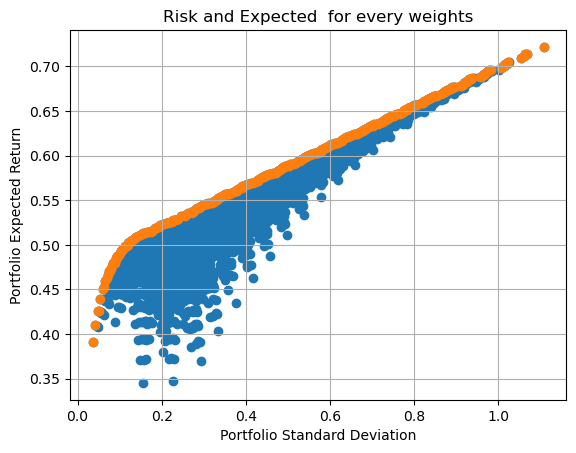

In [37]:
every_expected_risk = np.array(every_expected_risk)
plt.scatter(every_expected_risk[:,0],every_expected_risk[:,1])
plt.scatter(non_dominated_p[:,0],non_dominated_p[:,1])
plt.xlabel('Portfolio Standard Deviation')
plt.ylabel('Portfolio Expected Return')
plt.title('Risk and Expected  for every weights')
plt.grid(True)

In [38]:
results = np.concatenate((stocks.valid_weights()[non_dominated_p_indexes],non_dominated_p) , axis=1)
column_name = ['w1' , 'w2' , 'w3' , 'w4' , 'w5' ,'Expected' , 'Risk']
df = pd.DataFrame(results, columns=column_name)
df

,w1,w2,w3,w4,w5,Expected,Risk
0,0.00,0.00,0.00,0.00,1.00,0.036196,0.390844
1,0.00,0.00,0.00,0.05,0.95,0.042152,0.409718
2,0.00,0.00,0.00,0.15,0.85,0.048108,0.425689
3,0.00,0.00,0.00,0.25,0.75,0.051631,0.425987
4,0.00,0.00,0.00,0.30,0.70,0.054063,0.439074
...,...,...,...,...,...,...,...
320,0.95,0.00,0.00,0.00,0.05,1.054848,0.708934
321,0.95,0.00,0.00,0.05,0.00,1.060804,0.711322
322,0.95,0.00,0.05,0.00,0.00,1.064327,0.713475
323,0.95,0.05,0.00,0.00,0.00,1.067748,0.713592
